# Figures
Use `micromamba activate benchmark_env`.

In [1]:
library(ggplot2)
library(tidyverse)

── Attaching core tidyverse packages ─────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ lubridate 1.9.3     ✔ tibble    3.2.1
✔ purrr     1.0.2     ✔ tidyr     1.3.1
── Conflicts ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


Rows: 6 Columns: 4
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): lib_name, model
dbl (2): gen_time_role, gen_time_reason

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Saving 7 x 7 in image


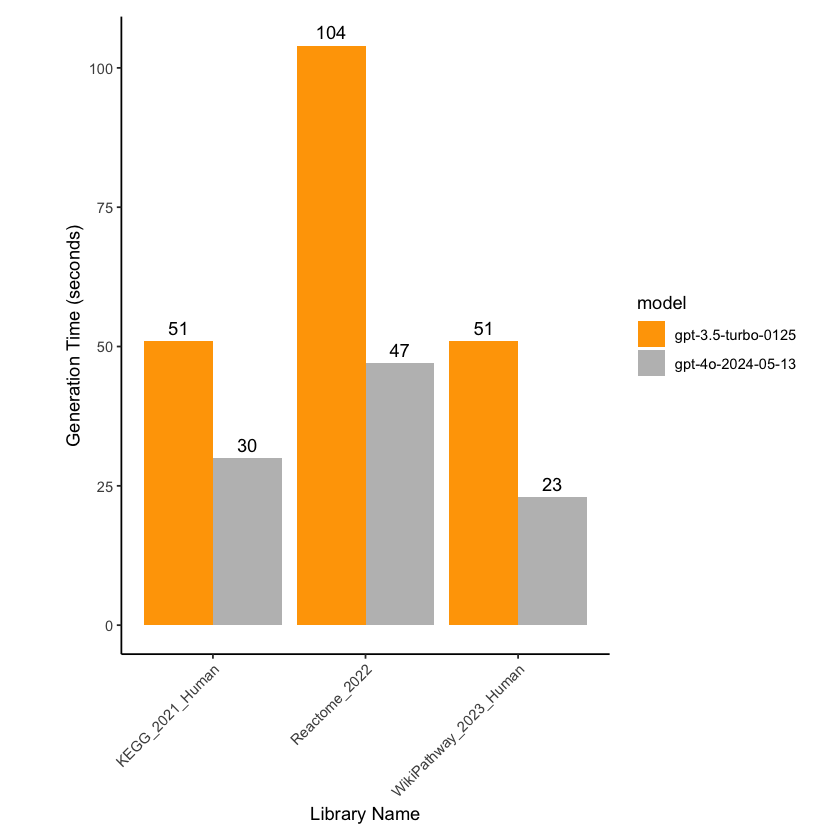

In [5]:
data <- readr::read_tsv("gen_time.tsv")
data$gen_time_role <- round(data$gen_time_role)

gen_fig <- ggplot(data, aes(x = lib_name, y = gen_time_role, fill = model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_text(aes(label = gen_time_role), position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(x = "Library Name", y = "Generation Time (seconds)") +
  theme_classic() +
  scale_fill_manual(values = c("gpt-3.5-turbo-0125" = "orange", "gpt-4o-2024-05-13" = "gray")) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(10, 10, 10, 40)
  )

ggsave(gen_fig, file="figures/gen_plot.pdf")
gen_fig

Rows: 12 Columns: 4
── Column specification ─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): lib_name, model
dbl (2): in_toks, out_toks

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


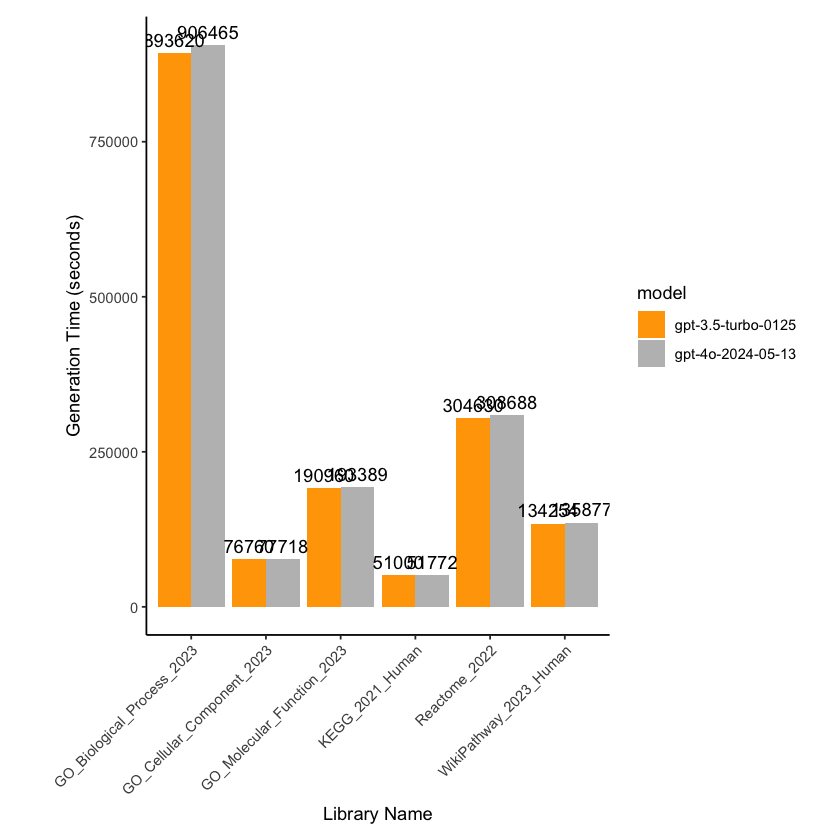

In [3]:
data <- readr::read_tsv("tok_use.tsv")

gen_fig <- ggplot(data, aes(x = lib_name, y = in_toks, fill = model)) +
  geom_bar(stat = "identity", position = position_dodge()) +
  geom_text(aes(label = in_toks), position = position_dodge(width = 0.9), vjust = -0.5) +
  labs(x = "Library Name", y = "Generation Time (seconds)") +
  theme_classic() +
  scale_fill_manual(values = c("gpt-3.5-turbo-0125" = "orange", "gpt-4o-2024-05-13" = "gray")) +
  theme(
    axis.text.x = element_text(angle = 45, hjust = 1),
    plot.margin = margin(10, 10, 10, 40)
  )

#ggsave(gen_fig, file="figures/gen_plot.pdf")
gen_fig

In [16]:
# Group by model and sum in_toks and out_toks
summarized_df <- data %>%
  group_by(model) %>%
  summarise(
    total_in_toks = sum(in_toks, na.rm = TRUE),
    total_out_toks = sum(out_toks, na.rm = TRUE)
  )
summarized_df

model,total_in_toks,total_out_toks
<chr>,<dbl>,<dbl>
gpt-3.5-turbo-0125,1651224,1633856
gpt-4o-2024-05-13,1673909,2893144


In [6]:
data <- readr::read_tsv("genes_overlap.tsv")

Rows: 23512 Columns: 14
── Column specification ───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr  (4): database, model, gene_set, descr
dbl (10): ncurated, nllm, ninter, generatio, recallratio, bgratio, non_hgcn,...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
data

database,model,gene_set,descr,ncurated,nllm,ninter,generatio,recallratio,bgratio,non_hgcn,ndup,p_val,p_val_adj
<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,ABC transporters,45,21,19,0.9047619,0.422222222,0.002267459,0,0,1.445517e-50,4.625655e-48
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,AGE-RAGE signaling pathway in diabetic complications,100,15,3,0.2000000,0.030000000,0.005038799,10,0,5.486356e-05,1.755634e-02
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,AMPK signaling pathway,120,9,6,0.6666667,0.050000000,0.006046559,3,0,3.697053e-12,1.183057e-09
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,Acute myeloid leukemia,67,56,9,0.1607143,0.134328358,0.003375995,1,0,2.244799e-13,7.183358e-11
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,Adherens junction,71,11,5,0.4545455,0.070422535,0.003577547,0,0,2.348603e-10,7.515531e-08
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,Adipocytokine signaling pathway,69,24,13,0.5416667,0.188405797,0.003476771,0,0,8.274617e-27,2.647877e-24
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,Adrenergic signaling in cardiomyocytes,150,40,18,0.4500000,0.120000000,0.007558198,0,23,2.549946e-28,8.159828e-26
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,African trypanosomiasis,37,20,5,0.2500000,0.135135135,0.001864356,1,0,2.606978e-10,8.342329e-08
KEGG_2021_Human,gpt-3.5-turbo-0125,llm_genes_role,"Alanine, aspartate and glutamate metabolism",37,16,10,0.6250000,0.270270270,0.001864356,1,4,1.082447e-24,3.463830e-22
